# Comparing Measured and True x and Q<sup>2</sup>

One of the main goals of analysis of simulated data is to determine how well we will be able to measure the quantities we set out to measure. Since we have access to 'truth' information as well as the 'observed' quantities for the same event, we can make simple comparison.

Let us start again from the $x$ and $Q^2$ calculations in a previous notebook.

## Importing packages

Depending on the versions of uproot and XRootD that you have installed, you may encouter a warning from uproot below. Nevertheless, because of the simple data format of the ATHENA ROOT files, we are able to ignore this warning.

In [175]:
import numpy as np
import uproot as ur
import awkward as ak
import matplotlib.pyplot as plt

## Opening a file with uproot

To test uproot, we will open a sample file (a DIS simulation sample):

In [176]:
server = 'root://sci-xrootd.jlab.org//osgpool/eic/'
file = 'ATHENA/RECO/master/DIS/NC/18x275/minQ2=1000/pythia8NCDIS_18x275_minQ2=1000_beamEffects_xAngle=-0.025_hiDiv_1.0001.root'

In [177]:
events = ur.open(server + file + ':events')

## Accessing the reconstructed particle momentum

For this analysis we will only use the three-momentum `p` and the particle identication code `pid`. We will select only electrons (`pid == 11`) and combine them with their initial momentum $\vec{p}_0$ which, in the ATHENA coordinate system, is in the negative $z$ direction by definition.

In [178]:
reconstructed_particles = events['ReconstructedParticles'].arrays()

In [179]:
kp1, kp2, kp3 = reconstructed_particles['ReconstructedParticles.p.x'], reconstructed_particles['ReconstructedParticles.p.y'], reconstructed_particles['ReconstructedParticles.p.z']
pid = reconstructed_particles['ReconstructedParticles.pid']
m = reconstructed_particles['ReconstructedParticles.mass']

## Determining the momentum transfer $Q^2$

For all particles we can calculate the energy, which we will consider the zeroth component of the four-momentum $p$.

In [180]:
kp0 = np.sqrt(m**2+(kp1**2+kp2**2+kp3**2))

The four-momentum of the incoming electron beam has only a $p_z$ and $E$ component.

In [181]:
k3 = -18
m0 = 0.000511
k0 = np.sqrt(m0**2 + k3**2)

We can now calculate the components of the four-momentum transfer $q_\mu = (k_\mu - k'_\mu)$:

In [182]:
q0 = k0 - kp0
q1 =    - kp1
q2 =    - kp2
q3 = k3 - kp3

With the four components we can form the squared four-momentum transfer, a scalar quantity, which is $Q^2 = -q^2$:

In [183]:
Q2 = -(q0**2 - q1**2 - q2**2 - q3**2)

## Determining the momentum fraction $x$

In order to determine $x$ we also need the incoming proton momentum $\vec{p}$. While it might be appealing to think that the proton momentum must be exactly along the $z$ axis as well, this is not the case in the interaction points of the EIC. At interaction point 6 (IP6), the crossing angle is -25 mrad in the $xz$ plane. Thus, the proton four-momentum is:

In [184]:
alpha = -0.025
p1 = 275 * np.sin(alpha)
p2 = 0
p3 = 275 * np.cos(alpha)
p0 = np.sqrt(0.938**2 + p1**2 + p2**2 + p3**2)

With this proton four-momentum we can now calculate the product $p \cdot q$, another scalar quantity:

In [185]:
pq = p0 * q0 - p1 * q1 - p2 * q2 - p3 * q3

and finally also $x = \frac{Q^2}{2 pq}$:

In [186]:
x = 0.5 * Q2 / pq

## Determining the true $x$ 

Because we have access to the `mcparticles2` branch, we can determine the 'true' $x$. For the sake of this tutorial, let's use the lab frame quantities to construct that value of $x$.

In [187]:
pdgID = events['mcparticles2.pdgID'].array()
status = events['mcparticles2.genStatus'].array()
psx,psy,psz = events['mcparticles2.ps.x'].array(), events['mcparticles2.ps.y'].array(), events['mcparticles2.ps.z'].array()

We can calculate the lab angles, and electron energies. Those give us the true $Q^2$.

In [188]:
E = 18
Ep = np.sqrt(0.000511**2 + psx**2 + psy**2 + psz**2)
theta = np.arctan2(np.sqrt(psx**2 + psy**2), psz)
Q2_true = 2 * E * Ep * (1 + np.cos(theta))

We can also calculate the true $y$, the center of mass energy $s$, and the true $x$.

In [189]:
y_true = 1 - 0.5 * Ep / E * (1 - np.cos(theta))
s = 4 * 18 * 275
x_true = Q2_true / s / y_true

In [190]:
np.sqrt(s)

140.71247279470288

We still have to select our primary events: all calculations above also included protons, pions, and even particles that are internal to the generator and never intended to be simulated.

In [191]:
select = np.logical_and((status == 1), (pdgID == 11))

## Comparing the true $x$ and observed $x$

So, how well did we do? Let's take a look at the numbers first.

In [192]:
print(x[pid == 11])
print(x_true[select])

[[0.107, 9.17e-05], [0.442, 0.000376], [0.177], ... [0.128], [0.297], [], []]
[[0.104, 9.04e-05], [0.396, 0.000382], [0.174], ... [0.127], [0.268], [], []]


In [193]:
print(Q2[pid == 11])
print(Q2_true[select])

[[1.25e+03, 1.81], [1.08e+03, 7.44], [1.34e+03], ... [1.32e+03], [1.18e+03], [], []]
[[1.24e+03, 1.79], [1.07e+03, 7.57], [1.34e+03], ... [1.33e+03], [1.18e+03], [], []]


We notice that the values are clearly not 100% identical, but we notice a few other things as well:
- There are multiple electrons in each events, and we have to make sure we compare the same values.
- There are even negative signs for $x$.

Whereas the mathematical calculation of $x$ for a scattered electron guarantees a value between 0 and 1, that is not true anymore when we combine measured momenta (which can be reconstructed as larger than the beam energy due to resolution effects), or when angles can be reconstructed differently from the actual scattering angle.

If we wish to plot the observed and true values of $x$ with respect to each others, we will need to ensure that the two structures are identical: one and only one entry per event, or none at all for either. Let's use the electron with the largest $Q^2$ in each event.

In [201]:
Q2_true_largest = ak.to_numpy(ak.max(Q2_true[select],1))
Q2_meas_largest = ak.to_numpy(ak.max(Q2[pid == 11],1))
Q2_ratio_meas_to_true = Q2_meas_largest / Q2_true_largest

/srv/conda/envs/notebook/lib/python3.7/site-packages/numpy/ma/core.py:1158: RuntimeWarning: overflow encountered in true_divide
  result = self.f(da, db, *args, **kwargs)


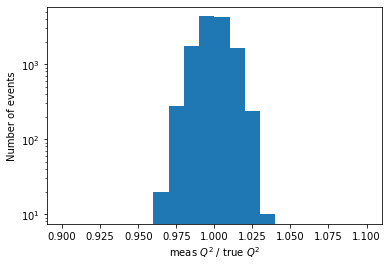

In [203]:
plt.hist(Q2_ratio_meas_to_true, range=[0.9, 1.1], bins = 20)
plt.yscale('log')
plt.xlabel('meas $Q^2$ / true $Q^2$')
plt.ylabel('Number of events')
plt.show()

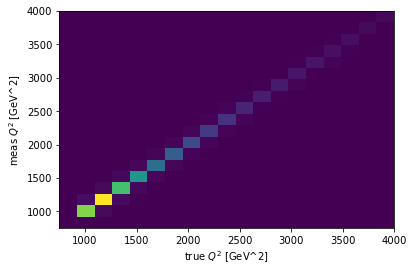

In [195]:
Q2_bins = np.linspace(750,4e3,20)
plt.hist2d(Q2_true_largest, Q2_meas_largest, bins = [Q2_bins, Q2_bins])
plt.xlabel('true $Q^2$ [GeV^2]')
plt.ylabel('meas $Q^2$ [GeV^2]')
plt.show()

Now we have to get the $x$ values to use the corresponding values.

In [196]:
x_true_largestQ2 = np.array(ak.to_numpy(x_true[Q2_true==ak.max(Q2_true[select],1)]))
x_meas_largestQ2 = np.array(ak.to_numpy(x[Q2==ak.max(Q2[pid==11],1)]))
x_ratio_meas_to_true = x_meas_largestQ2 / x_true_largestQ2

We can now plot both a histogram of the ratio and another scatter plot.

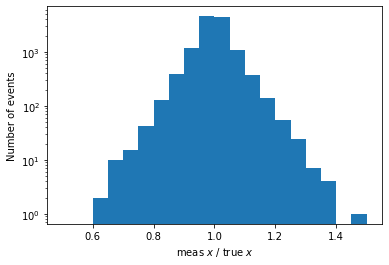

In [197]:
plt.hist(x_ratio_meas_to_true, range=[0.5, 1.5], bins = 20)
plt.yscale('log')
plt.xlabel('meas $x$ / true $x$')
plt.ylabel('Number of events')
plt.show()

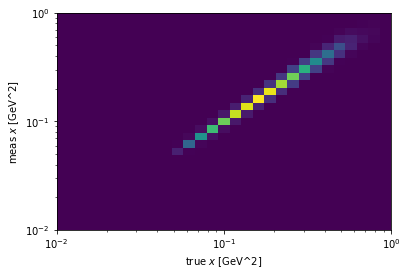

In [200]:
x_bins = np.logspace(-2,0,30)
plt.hist2d(x_true_largestQ2[:,0], x_meas_largestQ2[:,0], bins = [x_bins, x_bins])
plt.xscale('log')
plt.yscale('log')
plt.xlabel('true $x$ [GeV^2]')
plt.ylabel('meas $x$ [GeV^2]')
plt.show()